# HW 8 : Forward Filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv("simdata.csv")
vy = df.values[0][1:]
mF = df.values[1:][:, 1:]
T, p = vy.shape[0], mF.shape[0]
vm0 = np.zeros((p, 1))
mC0 = 0.1*np.eye(p)
amG = [np.eye(p)]*T
amW = [0.1 * np.eye(p)]*T
vV = 0.5 * np.ones(T)

In [2]:
# prepare
    
def FF(vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    
    
    vm = vm0
    mC = mC0
    
    # main loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        mm[t, :] = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        amC[t] = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        
    return mm, amC

In [3]:
mm, mC = FF(vy, mF, vV, amG, amW, vm0, mC0)
b1, b2, b3, b4 = mm[:, 0], mm[:, 1], mm[:, 2] ,mm[:, 3]

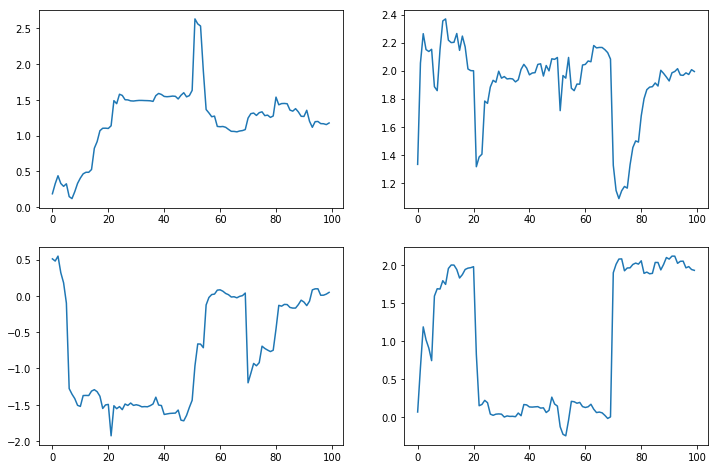

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 1].plot(b2)
ax[1, 0].plot(b3)
ax[1, 1].plot(b4)

# HW 9 (Q1 a): Forward Filtering and Backward Sampling 

In [49]:
amb = [0]*(T-1)
def FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    if m.ndim == 1:
        mb = np.random.normal(m.astype(np.float64), C_float, size = nsim)
    else:
        mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
    amb[T-2] = mb
    
    for t in reversed(range(T-1)):
        
        if m.ndim == 1:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), 1/amR[t+1].astype(np.float64))
            
        else:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), np.linalg.inv(amR[t+1].astype(np.float64)))
            
        mH = amC[t]- np.dot(np.dot(mB, amR[t+1]), mB.T)
        mean = mm[t, :] + (mb - ma[t, :])*mB
        H_float = mH.astype(np.float64)
        
        if m.ndim == 1:
            mb = mean.astype(np.float64) + np.random.normal(np.zeros(p), H_float, size = nsim)
        else:
            mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(p), H_float, size = nsim)
        amb[t] = mb
        
    return amb

In [40]:
nsim  = 5000
amb = FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0)

[[0.14493888]
 [0.30278561]
 [0.40305974]
 [0.61849454]
 [0.69386224]
 [0.86088098]
 [1.0620835 ]
 [1.11326541]
 [0.9825792 ]
 [1.2034062 ]
 [1.19131582]
 [1.38604336]
 [1.54905221]
 [1.52165456]
 [1.47594499]
 [1.64425931]
 [1.65901684]
 [1.87087229]
 [1.99613263]
 [1.9034432 ]
 [1.97290443]
 [1.99255618]
 [1.73198271]
 [1.88667577]
 [2.00483002]
 [1.95314674]
 [1.7320347 ]
 [1.83407492]
 [1.9561451 ]
 [1.79177897]
 [1.74502598]
 [1.68222261]
 [1.79997462]
 [1.9036404 ]
 [1.95972734]
 [2.05528005]
 [1.91772423]
 [1.55155583]
 [1.66031955]
 [1.80417767]
 [1.8595326 ]
 [1.954046  ]
 [2.0380873 ]
 [2.13183923]
 [1.99845781]
 [1.99940659]
 [2.08582456]
 [2.16026693]
 [1.60914537]
 [1.79600703]
 [1.9450219 ]
 [1.94434471]
 [1.80976253]
 [1.90452172]
 [1.83156229]
 [1.8692269 ]
 [1.89389707]
 [1.92754982]
 [1.90210369]
 [2.02008682]
 [2.10634352]
 [2.13980436]
 [2.12260773]
 [2.18952259]
 [2.20112904]
 [1.97137719]
 [1.93140195]
 [1.93792797]
 [2.02686621]
 [2.10361059]
 [2.19240198]
 [2.05

ValueError: shapes (5000,) and (1,) not aligned: 5000 (dim 0) != 1 (dim 0)

In [41]:
# aggregate

b1 = np.zeros(T)
b2 = np.zeros(T)
b3 = np.zeros(T)
b4 = np.zeros(T)
beta = [b1, b2, b3, b4]

for t in range(T-1):
    for i in range(p):
        beta[i][t] = np.mean(amb[t][:, i])

TypeError: 'int' object is not subscriptable

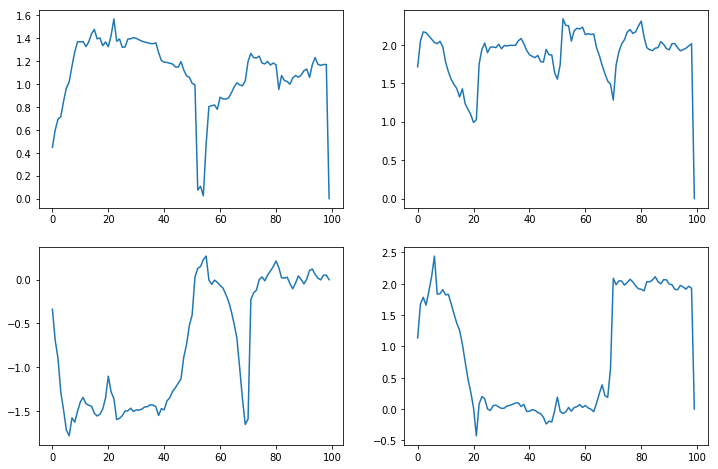

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 1].plot(b2)
ax[1, 0].plot(b3)
ax[1, 1].plot(b4)

# HW 9 (Q2 b) : Stochastic Volatity Model

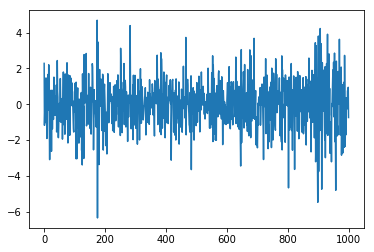

In [9]:
# data
svdata = pd.read_csv("sv_simdata.csv")
vy = svdata.values[0]
plt.plot(vy)

In [22]:
# true parameters
T = vy.shape[0]
vm0 = np.array([0])
mC0 = np.array([0.1])
dmu = np.array([0])
dphi = np.array([0.95])
dsig2 = np.array([0.1])
amG = [dphi]*T
amW = [dsig2]*T

In [23]:
# approximation
vy = np.array([np.log(i**2) + 1.27 - dmu for i in vy])
vV = 2.22**2 * np.ones(T)
mF = np.ones((1, T))

In [50]:
nsim = 2
svamb = FFBS(nsim,vy,mF,vV,amG,amW,vm0,mC0);

[0.36860602 0.75550313]
[0.85664399]
[0.46517087 0.78287026]
[0.85664399]
[0.13925695 0.48810944]
[0.85664399]
[-0.02795701  0.3010118 ]
[0.85664399]
[0.33161585 0.58514724]
[0.85664399]
[0.59980748 0.75525848]
[0.85664399]
[0.46140939 0.74013939]
[0.85664399]
[0.1876222  0.56054282]
[0.85664399]
[0.31905589 0.4337159 ]
[0.85664399]
[0.01558174 0.19060129]
[0.85664399]
[-0.10275635  0.19219389]
[0.85664399]
[-0.01155127  0.39907327]
[0.85664399]
[0.19262901 0.64540661]
[0.85664399]
[0.38230203 0.82995496]
[0.85664399]
[0.43028218 0.93929245]
[0.85664399]
[0.6981804  1.12607929]
[0.85664399]
[0.55704224 1.02580946]
[0.85664399]
[0.64957905 0.88077331]
[0.85664399]
[0.54270193 0.82218843]
[0.85664399]
[0.5210517  0.98158299]
[0.85664399]
[0.64430608 0.97813189]
[0.85664399]
[0.46786722 0.74473054]
[0.85664399]
[0.61696999 0.73132378]
[0.85664399]
[0.82528266 0.86214413]
[0.85664399]
[0.85190589 0.8625823 ]
[0.85664399]
[0.66104488 0.8044191 ]
[0.85664399]
[0.62603665 0.73215777]
[0.85664

[0.79010465 0.85718582]
[0.85664399]
[0.85142983 0.9694565 ]
[0.85664399]
[0.94373176 0.86008835]
[0.85664399]
[1.09621907 0.92868492]
[0.85664399]
[0.53033012 0.33239286]
[0.85664399]
[ 0.0094105 -0.2068793]
[0.85664399]
[ 0.19621351 -0.13918685]
[0.85664399]
[0.36631243 0.05702078]
[0.85664399]
[0.61148134 0.16141807]
[0.85664399]
[0.7288783  0.44459288]
[0.85664399]
[0.90289598 0.52732113]
[0.85664399]
[0.76951164 0.66739696]
[0.85664399]
[0.91349283 0.69115269]
[0.85664399]
[0.95919149 0.98475081]
[0.85664399]
[1.12209916 1.06754164]
[0.85664399]
[1.06545641 1.00591412]
[0.85664399]
[0.38694492 0.45690349]
[0.85664399]
[-0.31567458 -0.08882211]
[0.85664399]
[-0.11748617 -0.08952413]
[0.85664399]
[-0.00750519  0.04902881]
[0.85664399]
[0.19017845 0.17839792]
[0.85664399]
[0.30137704 0.36998778]
[0.85664399]
[0.42451567 0.30682215]
[0.85664399]
[0.54139992 0.46107251]
[0.85664399]
[0.73075464 0.53008573]
[0.85664399]
[0.6307543  0.59771755]
[0.85664399]
[0.79112341 0.77431722]
[0.856

[0.85664399]
[0.61424089 0.72720931]
[0.85664399]
[0.86154583 1.05105596]
[0.85664399]
[0.76769257 0.96693822]
[0.85664399]
[0.82792132 0.79009941]
[0.85664399]
[0.99490619 0.90811602]
[0.85664399]
[1.26323806 1.15091896]
[0.85664399]
[1.33765546 1.34097695]
[0.85664399]
[1.34833896 1.54977994]
[0.85664399]
[1.43253465 1.50240662]
[0.85664399]
[1.46656917 1.39530295]
[0.85664399]
[1.78580767 1.63386948]
[0.85664399]
[1.85900687 1.6142404 ]
[0.85664399]
[2.10305777 1.83547091]
[0.85664399]
[1.71611924 1.44125203]
[0.85664399]
[1.08003557 1.00270467]
[0.85664399]
[1.30518773 1.25581232]
[0.85664399]
[1.30343438 1.3950997 ]
[0.85664399]
[1.3770516 1.6232759]
[0.85664399]
[0.36728917 0.69726676]
[0.85664399]
[-0.78998721 -0.60290338]
[0.85664399]
[-0.80904302 -0.73962008]
[0.85664399]
[-0.48991447 -0.34185659]
[0.85664399]
[-0.34908822  0.00169531]
[0.85664399]
[-0.14820932  0.10068894]
[0.85664399]
[0.06413766 0.23309643]
[0.85664399]
[0.01782259 0.19916108]
[0.85664399]
[0.16172613 0.155